In [1]:
import os
import sys
import random
import warnings

import wandb
import torch
import numpy as np
from tqdm import tqdm
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rasterio
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

from src.vit_spatial_spectral import ViTSpatialSpectral
from src.utils import (
    get_supervised_data,
    load_checkpoint,
    get_finetune_config,
    get_val_epochs,
    train_step,
)
from src.data_enmap import dfc_labels_train, StandardizeEnMAP
del dfc_labels_train[-1] # remove 'Invalid' class from legend
from src.utils import validate_downstream as validate

# Inference Example
* Spatial spectral ViT, fine-tuned for 10 epochs on EnMAP-DFC data

In [2]:
SEED = 5
dataset_name = "enmap"

In [3]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

valid_datasets = ["enmap", "houston2018"]

assert (
    dataset_name in valid_datasets
), f"Please provide a valid dataset name from {valid_datasets}, provided: {dataset_name=}"

In [5]:
config = get_finetune_config(
    f"configs/finetune_config_{dataset_name}.yaml",
    "configs/config.yaml",
    SEED,
    device,
)

In [6]:
config.checkpoint_path = "checkpoints/finetuned_ViTSpatialSpectral_10ep_enmap.pth"
config.spectral_pos_embed = False

In [7]:
config.method_name

'ViTSpatialSpectral'

In [8]:
model = ViTSpatialSpectral(
            image_size=config.image_size - config.patch_sub,
            spatial_patch_size=config.patch_size,
            spectral_patch_size=config.band_patch_size,
            num_classes=config.n_classes,
            dim=config.transformer_dim,
            depth=config.transformer_depth,
            heads=config.transformer_n_heads,
            mlp_dim=config.transformer_mlp_dim,
            dropout=config.transformer_dropout,
            emb_dropout=config.transformer_emb_dropout,
            channels=config.n_bands,
            spectral_pos=config.spectral_pos,
            spectral_pos_embed=config.spectral_pos_embed,
            blockwise_patch_embed=config.blockwise_patch_embed,
            spectral_only=config.spectral_only,
            pixelwise=config.pixelwise,
            pos_embed_len=config.pos_embed_len,
        )
f"Model parameters: {sum([p.numel() for p in model.parameters()]):,}"

'Model parameters: 1,821,564'

In [9]:
config.checkpoint_path

'checkpoints/finetuned_ViTSpatialSpectral_10ep_enmap.pth'

In [10]:
model.load_state_dict(torch.load(config.checkpoint_path)["model_state_dict"])
model.to(device)
model.eval()

ViTSpatialSpectral(
  (to_patch_embedding): BlockwisePatchEmbedding(
    (pre_norm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    (post_norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (to_patch): Rearrange('b (c p0) (h p1) (w p2) -> b c (h w) (p0 p1 p2)', p0=10, p1=1, p2=1)
    (blockwise_embed): ModuleList(
      (0-19): 20 x Linear(in_features=10, out_features=96, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (spatial_spectral_transformer): Sequential(
    (0): Rearrange('b (c h w) d -> (b c) (h w) d', c=20, h=8, w=8)
    (1): Transformer(
      (layers): ModuleList(
        (0-3): 4 x ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (attend): Softmax(dim=-1)
              (dropout): Dropout(p=0.1, inplace=False)
              (to_qkv): Linear(in_features=96, out_features=1536, bias=False)
              (to_out): Sequential(
          

In [11]:
_, val_dataloader = get_supervised_data(config, device)

self.pixel_location_file=None
Number of tiles: 286
len(train_dataset)=228
len(val_dataset)=58


In [12]:
for idx, batch in enumerate(val_dataloader):
    if idx == 2:
        break

In [13]:
scene = batch["img"].to(device)
label_map = batch["label"].to(device)
eff_size = config.image_size - config.patch_sub
predicted_map = torch.zeros(label_map.shape)

for x in tqdm(range(0, 64, eff_size)):
    for y in range(0, 64, eff_size):
        img = scene.narrow(2, x, eff_size).narrow(3, y, eff_size)
        label = label_map.narrow(1, x, eff_size).narrow(2, y, eff_size)
        if x + config.image_size > 64 or y + config.image_size > 64:
            continue
                
        output = model(img)

        pred = output.argmax(dim=1)
        predicted_map[:, x : x + eff_size, y : y + eff_size] = pred

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.57it/s]


In [14]:
f"Accuracy: {(predicted_map.cpu() == label_map.cpu()).sum() / predicted_map.cpu().numel():.3f}"

'Accuracy: 0.865'

In [15]:
# EnMAP specific
NODATA = -32768
R,G,B = 199,150,0 # band index

In [16]:
scene = scene.detach().cpu()
label_map = label_map.cpu()

In [17]:
standardizer = StandardizeEnMAP()
scene_orig = standardizer.reverse(scene)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


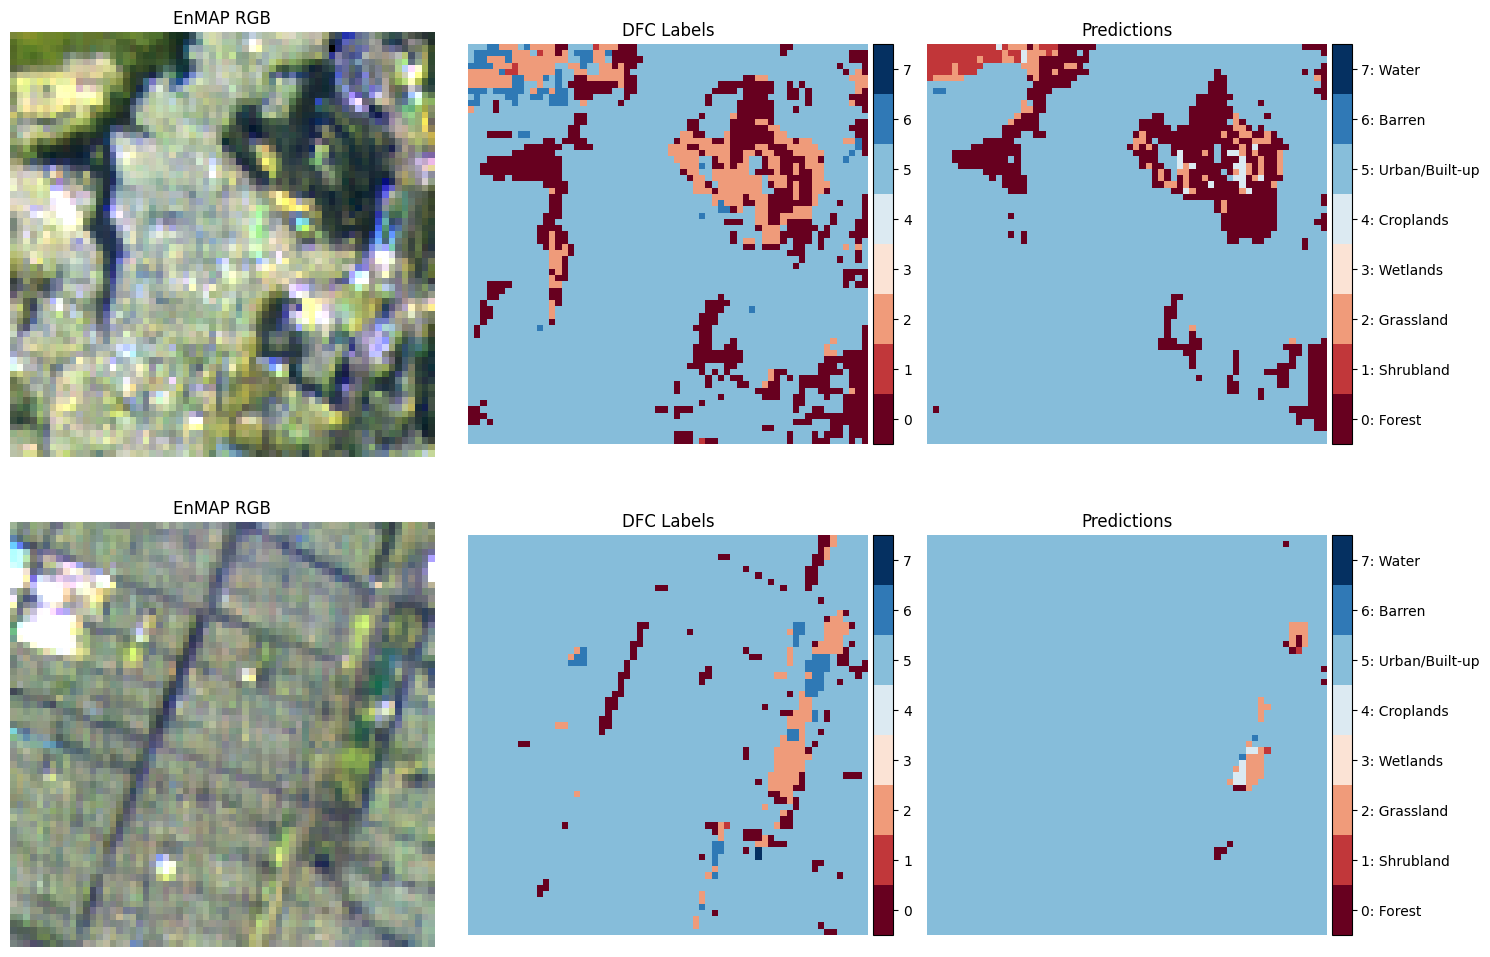

In [20]:
fig, axs = plt.subplots(2,3, figsize=(15,10))

for row in range(2):
    scene_rgb_norm = torch.moveaxis(scene_orig[row, [R,G,B]], 0, -1) / np.percentile(scene_orig[row, [R,G,B]], 98, axis=(1,2))
    axs[row, 0].imshow(scene_rgb_norm)
    axs[row, 0].set_title("EnMAP RGB")

    cmap = plt.get_cmap("RdBu", 7 - 0 + 1)

    mat1 = axs[row, 1].imshow(label_map[row], cmap=cmap, vmin=-0.5, vmax=7.5, interpolation="None")
    axs[row, 1].set_title("DFC Labels")

    divider = make_axes_locatable(axs[row, 1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(
         mat1, ticks=np.arange(0, 8), cax=cax, orientation="vertical"
    )

    mat2 = axs[row, 2].imshow(predicted_map[row], cmap=cmap, vmin=-0.5, vmax=7.5, interpolation="None")
    axs[row, 2].set_title("Predictions")

    divider = make_axes_locatable(axs[row, 2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(
         mat2, ticks=np.arange(0, 8), cax=cax, orientation="vertical"
    )
    
    cbar.ax.set_yticklabels([": ".join(map(str,x)) for x in zip(dfc_labels_train.keys(), dfc_labels_train.values())])

for ax in axs.flatten():
    ax.axis(False)

plt.tight_layout()
plt.show()